# SnowEx Database Preview
(15 minutes)

<img src='https://i.gifer.com/FH7W.gif' alt='fireworks' style='width:250px' />

Learning Objectives:

* First taste of the database!
* Code snippets to extract and prep data.
* Generate ideas for project pitches.

## The Basics
### How are the data contained?
<img src='./content/03_database-tables.png'>

## Set Up Computing Environment

In [1]:
# standard imports
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt 
import datetime

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas

**POINTER -->** Notice where I import the **four** primary database tables. Can anyone call out what code line does this from the code block above?

In [2]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


### What's the first thing you might like to do using the database?
Find overlapping data for data analysis comparison

### Example 1: Let's find all the pits that overlap with an airborne sensor of interest!
First, it would be helpful to know, which of the airborne sensors are part of the database, right?

In [3]:
# Query the session using .observers() to generate a list
qry = session.query(ImageData.observers)

# Locate all that are distinct
airborne_sensors_list = session.query(ImageData.observers).distinct().all()

print('list of airborne sensors by "observer" name: \n', airborne_sensors_list)

list of airborne sensors by "observer" name: 
 [('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]


### 1a). Unsure of the flight date, but know which sensor you'd like to overlap with, here's how: 

In [4]:
# Airborne sensor from list above
sensor = 'UAVSAR team, JPL'

# Form a query on the Images table that returns Raster collection dates
qry = session.query(ImageData.date)

# Filter for UAVSAR data
qry = qry.filter(ImageData.observers == sensor)

# Grab the unique dates
qry = qry.distinct()

# Execute the query 
dates = qry.all() 

# Clean up the dates 
dates = [d[0] for d in dates] 
dlist = [str(d) for d in dates]
dlist = ", ".join(dlist)
print('%s flight dates are: %s' %(sensor, dlist))

# Find all the snow pits done on these days
qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
qry = qry.filter(SiteData.date.in_(dates))

# Return a geopandas df
df = query_to_geopandas(qry, engine)

# View the returned dataframe!
print(df.head())
print(f'{len(df.index)} records returned!')

# Close your session to avoid hanging transactions
session.close()

UAVSAR team, JPL flight dates are: 2020-02-12, 2020-02-13, 2020-01-31, 2020-02-01, 2020-03-11, 2020-02-21
                             geom site_id        date
0  POINT (742229.000 4326414.000)    2C12  2020-02-12
1  POINT (745243.000 4322637.000)    6S26  2020-02-12
2  POINT (744824.000 4323962.000)    5N32  2020-02-12
3  POINT (744639.000 4323010.000)    FL1B  2020-02-12
4  POINT (743604.000 4324202.000)    5N24  2020-02-12
142 records returned!


### 1b).Want to select an exact flight date match? Here's how:

In [5]:
# Pick a day from the list of dates
dt = dates[0] 

# Find all the snow pits done on these days 
qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
qry = qry.filter(SiteData.date == dt)

# Return a geopandas df
df_exact = query_to_geopandas(qry, engine)

print('%s pits overlap with %s on %s' %(len(df_exact), sensor, dt))

# View snows pits that align with first UAVSAR date
df_exact.head()

40 pits overlap with UAVSAR team, JPL on 2020-02-12


,geom,site_id,date
0,POINT (742229.000 4326414.000),2C12,2020-02-12
1,POINT (745243.000 4322637.000),6S26,2020-02-12
2,POINT (744824.000 4323962.000),5N32,2020-02-12
3,POINT (744639.000 4323010.000),FL1B,2020-02-12
4,POINT (743604.000 4324202.000),5N24,2020-02-12


### 1c). Want to select a range of dates near the flight date? Here's how:

In [6]:
# Form a date range to query on either side of our chosen day 
date_range = [dt + i * datetime.timedelta(days=1) for i in [-1, 0, 1]]

# Find all the snow pits done on these days 
qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
qry = qry.filter(SiteData.date.in_(date_range))

# Return a geopandas df
df_range = query_to_geopandas(qry, engine)

# Clean up dates (for print statement only)
dlist = [str(d) for d in date_range]
dlist = ", ".join(dlist)

print('%s pits overlap with %s on %s' %(len(df_range), sensor, dlist))

# View snow pits that are +/- 1 day of the first UAVSAR flight date
df_range.sample(10)

53 pits overlap with UAVSAR team, JPL on 2020-02-11, 2020-02-12, 2020-02-13


,geom,site_id,date
49,POINT (737376.942 4368074.876),Forest,2020-02-12
35,POINT (446047.637 4493578.874),Atwater,2020-02-13
5,POINT (740919.000 4327334.000),1C5,2020-02-12
40,POINT (453358.065 4431449.820),Forest Flat,2020-02-12
31,POINT (754175.379 4325867.021),Skyway Tree,2020-02-12
50,POINT (737572.151 4368171.960),Open,2020-02-12
4,POINT (743604.000 4324202.000),5N24,2020-02-12
24,POINT (317172.112 4306473.210),Irwin Barn,2020-02-12
34,POINT (446677.235 4491448.536),Alta Collins,2020-02-13
8,POINT (743548.000 4324077.000),1N23,2020-02-11


### 1d). Have a known date that you wish to select data for, here's how:

In [7]:
# Find all the data that was collected on 2-12-2020
dt = datetime.date(2020, 2, 12)

#--------------- Point Data -----------------------------------
# Grab all Point data instruments from our date
point_instruments = session.query(PointData.instrument).filter(PointData.date == dt).distinct().all()
point_type = session.query(PointData.type).filter(PointData.date == dt).distinct().all()

# Clean up point data (i.e. remove tuple)
point_instruments = [p[0] for p in point_instruments if p[0] is not None]
point_instruments = ", ".join(point_instruments)
point_type = [p[0] for p in point_type]
point_type = ", ".join(point_type)
print('Point data on %s are: %s, with the following list of parameters: %s' %(str(dt), point_instruments, point_type))

#--------------- Layer Data -----------------------------------
# Grab all Layer data instruments from our date
layer_instruments = session.query(LayerData.instrument).filter(LayerData.date == dt).distinct().all()
layer_type = session.query(LayerData.type).filter(LayerData.date == dt).distinct().all()

# Clean up layer data 
layer_instruments = [l[0] for l in layer_instruments if l[0] is not None]
layer_instruments = ", ".join(layer_instruments)
layer_type = [l[0] for l in layer_type]
layer_type = ", ".join(layer_type)
print('\nLayer Data on %s are: %s, with the following list of parameters: %s' %(str(dt), layer_instruments, layer_type))

#--------------- Image Data -----------------------------------
# Grab all Image data instruments from our date
image_instruments = session.query(ImageData.instrument).filter(ImageData.date == dt).distinct().all()
image_type = session.query(ImageData.type).filter(ImageData.date == dt).distinct().all()

# Clean up image data 
image_instruments = [i[0] for i in image_instruments]
image_instruments = ", ".join(image_instruments)
image_type = [i[0] for i in image_type if i[0] is not None]
image_type = ", ".join(image_type)
print('\nImage Data on %s are: %s, with the following list of parameters: %s' %(str(dt), image_instruments, image_type))

Point data on 2020-02-12 are: camera, magnaprobe, pit ruler, with the following list of parameters: depth

Layer Data on 2020-02-12 are: IRIS, IS3-SP-11-01F, snowmicropen, with the following list of parameters: density, equivalent_diameter, force, grain_size, grain_type, hand_hardness, lwc_vol, manual_wetness, permittivity, reflectance, sample_signal, specific_surface_area, temperature

Image Data on 2020-02-12 are: UAVSAR, L-band InSAR, with the following list of parameters: insar amplitude, insar correlation, insar interferogram imaginary, insar interferogram real


### Example 2: Let's plot some snow pit temperature profiles from open canopy sites

In [8]:
# database imports (again)
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas

In [9]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


### Query the SiteData for a list of Time Series sites

In [10]:
# query all the sites by site id
qry = session.query(SiteData.site_id).distinct()

# filter out the Grand Mesa IOP sites (this also removes Grand Mesa Time Series sites, but okay for this example)
qry = qry.filter(SiteData.site_name != 'Grand Mesa') # != is "not equal to"

# second filter on open canopy sites
qry = qry.filter(SiteData.tree_canopy == 'No Trees')

# execute the query
ts_sites = qry.all()

# clean up to print a list of sites
ts_sites = [s[0] for s in ts_sites]
ts_sites_str = ", ".join(ts_sites)
print('list of Time Series sites:\n', ts_sites_str)

list of Time Series sites:
 JPL 1, Open, Open Flat, Joe Wright, Open 2, BA Flux Tower, Open 4, Saddle, Banner Open, Panorama Dome, Senator Beck, Swamp Angel, JPL 2, Mores Creek Summit, CUES, SNB 1, Michigan River, HQ Met Station, Alta Collins, Atwater, LDP Open, Gothic, Tower 4, Open 6


### Hold up, how did you know the 'special strings' to use?
If you want to quickly view the list of options available for a specific table column, try this:

1. Begin by going to the [Database Structure](https://snowexsql.readthedocs.io/en/latest/database_structure.html) page
2. Scroll down to Sites Table (for this example)
3. See the list of column options in the table? 

<img src='./content/03_db-structure-column-lookup.png'>

In [11]:
# Using the SiteData table, and from the link above use the columns you have access to:
locations = session.query(SiteData.site_name).distinct().all()
print('Regional Locations are: \n', locations)

canopy_options = session.query(SiteData.tree_canopy).distinct().all()
print('\nCanopy Options are: \n', canopy_options)

Regional Locations are: 
 [('Cameron Pass',), ('Sagehen Creek',), ('Fraser Experimental Forest',), ('Mammoth Lakes',), ('Niwot Ridge',), ('Boise River Basin',), ('Little Cottonwood Canyon',), ('East River',), ('American River Basin',), ('Senator Beck',), ('Jemez River',), ('Grand Mesa',)]

Canopy Options are: 
 [(None,), ('Open (20-70%)',), ('Closed (>70%)',), ('Sparse (5-20%)',), ('No Trees',)]


### Okay, read for the big piece? Let's plot temperature profiles through time at all the open sites
Steps: 
1. Use the list of Time Series sites we queried above (the "No Tree" sites, remember!)
2. Set up the figure and subplots and colorbar
3. Loop over a sites (e.g. Bogus Upper) and data parameter (e.g. temperature) in one query command
4. Loop over the dates and add a temperature profile plot to the figure. (This is a nested loop)
5. Style the plot axes

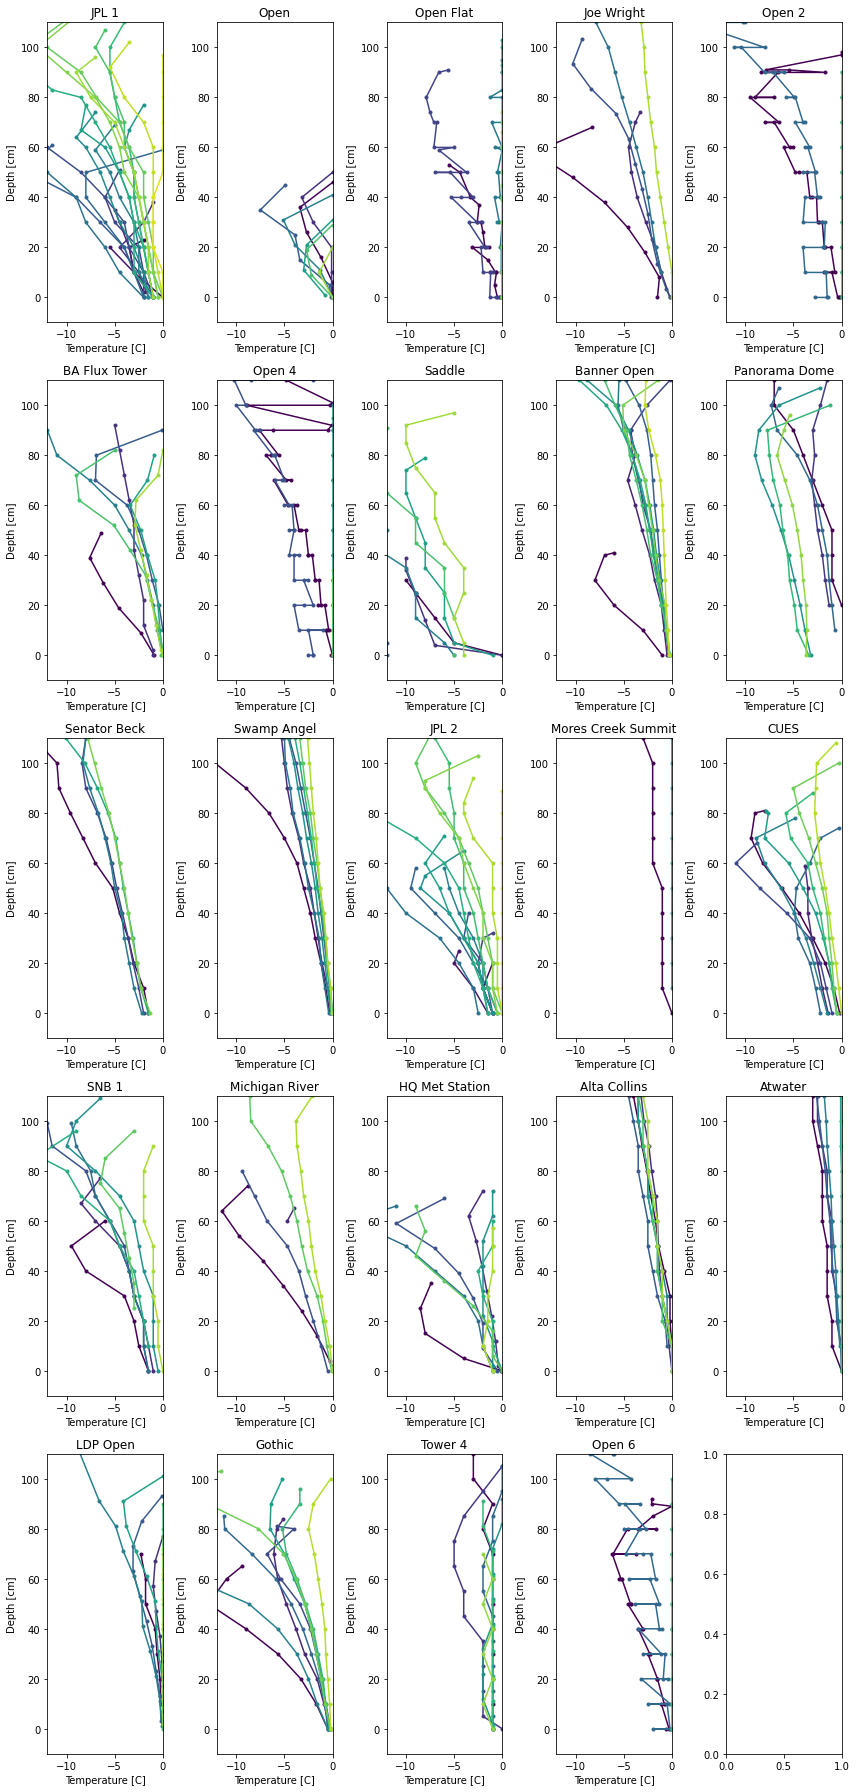

In [12]:
# 1. use the list of Time Series sites from above 
sites = ts_sites

# 2. setup the subplot for each site 
fig, axes = plt.subplots(len(sites)%5+1, 5, figsize=(12, 25))

# setup the colorbar
cmap = matplotlib.cm.get_cmap('viridis')

# 3. loop over sites and select the data parameter ('temperature')
for i, site in enumerate(sites):
    
    # query the database by site and for temperature profile data 
    qry = session.query(LayerData).filter(LayerData.site_id.in_([site])).filter(LayerData.type == 'temperature') 
    
    # convert to pandas dataframe  
    df = query_to_pandas(qry, engine)  
    
    # create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
    dates = sorted(df['date'].unique())
    
    # grab the plot for this site
    ax = axes.flatten()[i]
    
    # counter to help with plotting
    k=0
    
    
    # 4. loop over dates & plot temperature profile
    for j, date in enumerate(dates):
        
        # grab the temperature profile 
        profile = df[df.date == date]
        
        # don't plot it unless there is data, make sure the dataframe index is > 1
        if len(profile.index) > 0:            
            
            # sort by depth so samples that are taken out of order won't mess up the plot
            profile = profile.sort_values(by='depth')

            # cast as a float; layer profiles are always stored as strings
            profile['value'] = profile['value'].astype(float)

            # plot the temperature profile
            ax.plot(profile['value'], 
                    profile['depth'], 
                    marker='.',
                    color = cmap(k/len(dates)),
                    label=date) 
            # ax.legend()
            
            k+=1 
            
# 5. style the axes
for i, site in enumerate(sites):
    ax = axes.flatten()[i]
    ax.set_xlim(-12, 0)
    ax.set_ylim(-10, 110)
    ax.set_title(sites[i])
    ax.set_xlabel('Temperature [C]')
    ax.set_ylabel('Depth [cm]')

fig.tight_layout()

# close your database session
session.close()     

## Explore the Spatial Extent of Field Campaign Data
### Example 3. Geographically, where do we have measurements? 
This is my favorite part right here! We are using the ipyleaflet mapping package and our database queries to explore the database.

<img src='https://media.giphy.com/media/BPFEy7l8Z9eCphEnNc/giphy.gif' alt='fireworks' style='width:250px' />

In [13]:
# set a map extent
bbox = [-125, 49, -102, 31]

# set a bounding box
west, north, east, south = bbox

# add a little bbox buffer
bbox_ctr = [0.5*(north+south), 0.5*(west+east)]

In [14]:
# create a map, with a somewhat basic backdrop
m = Map(basemap=basemaps.CartoDB.Positron, center=bbox_ctr, zoom=4)

# add a rectangle to highlight the area of interest
rectangle = Rectangle(bounds=((south, west), (north, east))) #SW and NE corners of the rectangle (lat, lon)

# add the layer to the map object
m.add_layer(rectangle)

# view the map
m

Map(center=[40.0, -113.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

More information on available [basemaps](https://ipyleaflet.readthedocs.io/en/latest/map_and_basemaps/basemaps.html) using ipyleaflet

### Query the database to add spatial data to our map

In [15]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

### Let's find out where we have liquid water content (LWC) data 

**Pointer -->**  LWC data is in the LayerData table, because data at a single location were measured as a profile on the pit wall face (i.e has a vertical dimension) 

In [16]:
# query the LayerData for all LWC values, this combines a query, filter, and distinct
qry = session.query(LayerData.longitude, LayerData.latitude).filter(LayerData.type == 'lwc_vol').distinct() # 

# convert query to pandas df (LayerData doesn't have the 'geom' column, so can't do geopandas conversion yet
df = query_to_pandas(qry, engine)

# create the geopandas geometry column from the lat/lon in the pandas df
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

print(df.head())

# how many did we retrieve?
print(f'{len(df.index)} records returned!')

# close session to avoid hanging transactions 
session.close()

   longitude  latitude                     geometry
0 -120.29898  39.42216  POINT (-120.29898 39.42216)
1 -120.24212  39.42954  POINT (-120.24212 39.42954)
2 -120.24211  39.42968  POINT (-120.24211 39.42968)
3 -120.24203  39.42957  POINT (-120.24203 39.42957)
4 -120.23982  39.43036  POINT (-120.23982 39.43036)
529 records returned!


### Let's add these points to our map!

In [17]:
# same basemap as above
m = Map(basemap=basemaps.CartoDB.Positron, center=bbox_ctr, zoom=4)

# create a geo_data object
geo_data = GeoData(geo_dataframe = df,
    style={'color': 'black', 'radius':8, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'yellow', 'weight': 3},
    name = 'lwc obs.')

m.add_layer(geo_data) 
m.add_control(LayersControl())
m

Map(center=[40.0, -113.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

## Recap
* The database has a lot of power to compare coincident data sets and perform analysis once you gain a few navigational skills 
* Knowing the different types of data, where they are contained, and practicing queries will help with project work (and don't worry, this was only a preview!)
* ipyleaflet is a fun mapping tool!

## References 
several, but best to look at the database tutorial for a one-stop shop!

## Quiz Time! I mean group activity!
1. Navigate to this [Google Slides](https://docs.google.com/presentation/d/1tiEiYob_xdRlBXhYXTu-gqeYgOP3rhxjyTGcxXTC8_g/edit#slide=id.p10) page to complete the Data Table activity
2. As a large group, move the items into the appropriate database table panel